<a href="https://colab.research.google.com/github/jonik2909/computer-vision/blob/main/menu_detector_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
print("menu detector")

menu detector


In [21]:
# import libraries

from google.colab import drive
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.models import mobilenet_v2

from PIL import Image, UnidentifiedImageError
from torch.utils.data import Dataset, DataLoader
import os
import numpy as np


In [22]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
# Define Dataset Path

DATASET_PATH = '/content/drive/MyDrive/food101_dataset'
print("Dataset Path:", DATASET_PATH)

CUSTOM_CLASS_MAPPING = {
    'hamburger': 'hamburger',
    'hot_dog': 'hot_dog',
    'chocolate_cake': 'dessert', # label grouping | class consolidation
    'cheesecake': 'dessert', # label grouping | class consolidation
    'kebab': 'kebab',
    'pilaf': 'pilaf'
}

CLASSES = ['hamburger', 'hot_dog', 'dessert', 'kebab', 'pilaf']

CLASS_TO_IDX = {c: i for i, c in enumerate(CLASSES)}
NUM_CLASSES = len(CLASSES)

print("Classes:", CLASSES)
print("Class to Index Mapping:", CLASS_TO_IDX)
print("Number of Classes:", NUM_CLASSES)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])



Dataset Path: /content/drive/MyDrive/food101_dataset
Classes: ['hamburger', 'hot_dog', 'dessert', 'kebab', 'pilaf']
Class to Index Mapping: {'hamburger': 0, 'hot_dog': 1, 'dessert': 2, 'kebab': 3, 'pilaf': 4}
Number of Classes: 5


In [24]:
# ---------------------------
# Custom Dataset Class
# ---------------------------

class FoodDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        # print('images_length', len(self.images))
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        # print('image_path', img_path)
        label = self.labels[idx]
        # print('label', label)
        try:
            image = Image.open(img_path)
            if image.mode == "P" or image.mode == "RGBA": # png | gif |RGBA
              image = image.convert("RGB").convert("RGB")
            else:
              image = image.convert("RGB")
        except (UnidentifiedImageError, OSError):
            print(f"Skipping broken image: {img_path}")
            return self.__getitem__((idx + 1) % len(self.images)) #

        if self.transform:
            image = self.transform(image)
        return image, label

In [25]:
# ---------------------------
# Gather and Split Data
# ---------------------------
all_images = []
for original_class, mapped_class in CUSTOM_CLASS_MAPPING.items():
    class_path = os.path.join(DATASET_PATH, original_class) # /content/drive/MyDrive/food101_dataset/hamburger
    print('class_path:', class_path)
    if not os.path.exists(class_path):
        print(f"Warning: {class_path} not found")
        continue
    for img in os.listdir(class_path):
        if img.endswith(('.jpg', '.jpeg', '.png')): # .txt, .docx
            full_path = os.path.join(class_path, img) # /content/drive/MyDrive/food101_dataset/hamburger/100057.jpg
            all_images.append((full_path, CLASS_TO_IDX[mapped_class]))

np.random.shuffle(all_images)
split = int(0.8 * len(all_images))
train_data = all_images[:split] # 1000 | 800 train_data | 200 val_data
val_data = all_images[split:]

train_images, train_labels = zip(*train_data)
val_images, val_labels = zip(*val_data)

print('all_images:', all_images)

dataset = FoodDataset(train_images, train_labels)
print(len(dataset))
img, lbl = dataset[0]

class_path: /content/drive/MyDrive/food101_dataset/hamburger
class_path: /content/drive/MyDrive/food101_dataset/hot_dog
class_path: /content/drive/MyDrive/food101_dataset/chocolate_cake
class_path: /content/drive/MyDrive/food101_dataset/cheesecake
class_path: /content/drive/MyDrive/food101_dataset/kebab
class_path: /content/drive/MyDrive/food101_dataset/pilaf
all_images: [('/content/drive/MyDrive/food101_dataset/hamburger/3702789.jpg', 0), ('/content/drive/MyDrive/food101_dataset/hamburger/333517.jpg', 0), ('/content/drive/MyDrive/food101_dataset/hot_dog/842474.jpg', 1), ('/content/drive/MyDrive/food101_dataset/hot_dog/92535.jpg', 1), ('/content/drive/MyDrive/food101_dataset/hot_dog/3302187.jpg', 1), ('/content/drive/MyDrive/food101_dataset/hot_dog/2039913.jpg', 1), ('/content/drive/MyDrive/food101_dataset/hamburger/2591266.jpg', 0), ('/content/drive/MyDrive/food101_dataset/hamburger/2014421.jpg', 0), ('/content/drive/MyDrive/food101_dataset/chocolate_cake/2425586.jpg', 2), ('/content/

In [26]:
train_dataset = FoodDataset(train_images, train_labels, transform=transform)
val_dataset = FoodDataset(val_images, val_labels, transform=transform)

In [27]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2) # therad | parallel loading for speed
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

In [28]:
# pretrained model

model = mobilenet_v2(weights="IMAGENET1K_V1") # pretrained model | lightweight | CNN | 1000 class
model.classifier[1] = nn.Linear(model.classifier[1].in_features, NUM_CLASSES) # fine-tuning | backbone | model layer freeze

In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device:", device)
model = model.to(device)

device: cuda


In [30]:
criterion = nn.CrossEntropyLoss() # Loss Function | '70%' burger, '30%' pilaf
optimizer = optim.Adam(model.parameters(), lr=0.001) # weight
torch.backends.cudnn.benchmark = True # Benchmark Setting | Trick | 10%-20%

print('criterion:', criterion)
print('optimizer:', optimizer)

criterion: CrossEntropyLoss()
optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)


In [33]:
# ---------------------------
# Training Loop
# ---------------------------

NUM_EPOCHS = 10
best_accuracy = 0.0

for epoch in range(NUM_EPOCHS):
    model.train() # train mode
    running_loss = 0.0 # 70% | 30%Loss | 100%
    for images, labels in train_loader: # Forward and Backward(Backpropagation)
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad() # zero the gradient
        outputs = model(images) # Forward Pass | Dog | 5 Classes
        loss = criterion(outputs, labels) # Calculate Loss
        loss.backward()
        optimizer.step() # Adam optimizer
        running_loss += loss.item() # Track Loss

    # Validation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc = 100 * correct / total
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] Loss: {running_loss/len(train_loader):.4f}, Val Accuracy: {val_acc:.2f}%")

    if val_acc > best_accuracy:
        best_accuracy = val_acc
        torch.save(model.state_dict(), '/content/menu_detector.pth')
        print("Saved new best model!")


Epoch [1/10] Loss: 0.4451, Val Accuracy: 90.75%
Saved new best model!
Epoch [2/10] Loss: 0.2808, Val Accuracy: 90.02%
Epoch [3/10] Loss: 0.2092, Val Accuracy: 86.42%
Epoch [4/10] Loss: 0.2140, Val Accuracy: 86.42%
Epoch [5/10] Loss: 0.1686, Val Accuracy: 90.38%
Epoch [6/10] Loss: 0.1057, Val Accuracy: 89.78%
Epoch [7/10] Loss: 0.1292, Val Accuracy: 92.31%
Saved new best model!


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7997d184ab60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1707, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1690, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7997d184ab60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1707, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch [8/10] Loss: 0.1106, Val Accuracy: 87.98%


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7997d184ab60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1707, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1690, in _shutdown_workers
if w.is_alive():    
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7997d184ab60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1707, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch [9/10] Loss: 0.1049, Val Accuracy: 87.74%


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7997d184ab60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1707, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1690, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^AssertionError^
: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7997d184ab60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1707, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch [10/10] Loss: 0.1243, Val Accuracy: 90.02%


# **Menu Detector Model Usage**

device: cuda
Upload one or more images of your food:


Saving Uzbek-Palov.jpg to Uzbek-Palov (1).jpg


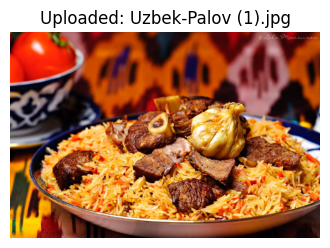

Prediction:
  ✅ pilaf: 99.60%
  ✅ kebab: 0.24%
  ✅ hot_dog: 0.09%
  ✅ hamburger: 0.06%


In [38]:
# ----------------------------------------
# Required Imports
# ----------------------------------------
import torch
import torchvision.transforms as transforms
from torchvision.models import mobilenet_v2
from PIL import Image
from google.colab import files
import io
import matplotlib.pyplot as plt

# ----------------------------------------
# Define Semantic Classes
# ----------------------------------------
CLASSES = ['hamburger', 'hot_dog', 'dessert', 'kebab', 'pilaf']  # Must match training order
NUM_CLASSES = len(CLASSES)
CLASS_TO_IDX = {cls: i for i, cls in enumerate(CLASSES)}

# ----------------------------------------
# Transform for Uploaded Images (no augmentations!)
# ----------------------------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# ----------------------------------------
# Load Model
# ----------------------------------------
model = mobilenet_v2(weights=None)
model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, NUM_CLASSES)
model.load_state_dict(torch.load('/content/menu_detector.pth', map_location='cpu'))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device:', device)
model = model.to(device)
model.eval()

# ----------------------------------------
# Upload & Predict
# ----------------------------------------
print("Upload one or more images of your food:")
uploaded = files.upload()

for image_name in uploaded.keys():
    image = Image.open(io.BytesIO(uploaded[image_name])).convert('RGB')

    # Display image
    plt.figure(figsize=(4, 4))
    plt.imshow(image)
    plt.axis('off')
    plt.title(f'Uploaded: {image_name}')
    plt.show()

    # Predict
    image_tensor = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(image_tensor)
        probs = torch.softmax(output, dim=1)[0]
        topk = torch.topk(probs, 4)

    print("Prediction:")
    for i in range(topk.indices.size(0)):
        label = CLASSES[topk.indices[i]]
        confidence = topk.values[i].item() * 100
        print(f"  ✅ {label}: {confidence:.2f}%")